In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

## Loading in TESS Sector 14 Data

In [3]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
#target = '273589987'
target='9726699'
gj1243_tess = search_lightcurvefile(target,cadence='short',mission='TESS').download_all()

In [4]:
gj1243_tess

LightCurveFileCollection of 2 objects:
	TIC 273589987 (2 TessLightCurveFiles) Sectors: 14,15

In [5]:
tess_collection=gj1243_tess[-2:]
tess_collection

[TessLightCurveFile(TICID: 273589987), TessLightCurveFile(TICID: 273589987)]

In [6]:
gj1243_tesslc = tess_collection[0].PDCSAP_FLUX.remove_nans()

for q in range(1,len(tess_collection)):
    try:
        gj1243_tesslc = gj1243_tesslc.append(tess_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


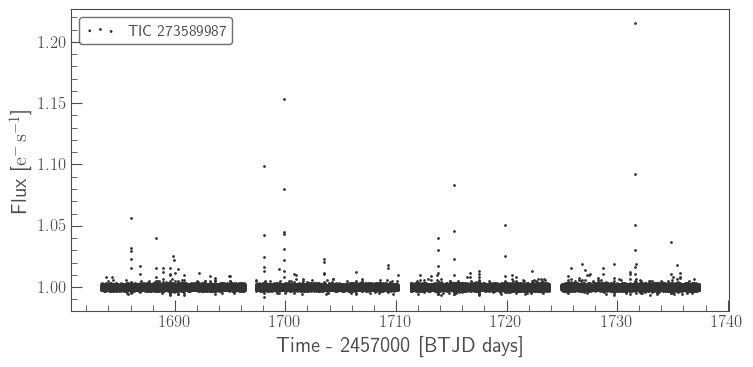

In [7]:
gj1243_tesslc.flatten(window_length=11).scatter()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

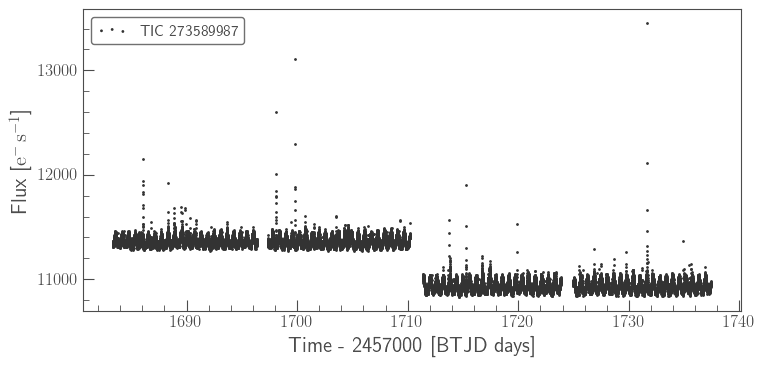

In [8]:
gj1243_tesslc.scatter()

## Loading in Flare Table (includes sector 14&15)

In [144]:
tess_flares= pd.read_csv('/Users/lupitatovar/TESS/all_tess_flares.txt',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [145]:
t_starts = tess_flares.loc[:,'t_start'].values
t_stops = tess_flares.loc[:,'t_stop'].values
flux_peak = tess_flares.loc[:,'Flux_peak'].values

In [146]:
len(tess_flares)

132

### Running GP on TESS Data

Masking out the flares

In [12]:
#mask array for TESS lightcurve
f_mask = np.zeros_like(gj1243_tesslc.time, dtype=bool)

In [13]:

for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5  
    buffer = (gj1243_tesslc.time >= t_starts[i] - c1*dur) & (gj1243_tesslc.time <= t_stops[i] + c2*dur)
    temp = (gj1243_tesslc.time >= t_starts[i]) & (gj1243_tesslc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)
no_flare = np.where((f_mask == False))[0]
flares = np.where((f_mask == True))[0]

[False False False ... False False False]


Accounting for quarterly discontinuities

In [14]:
total_median = np.nanmedian(gj1243_tesslc.flux[no_flare])
raw_flux = 1+((gj1243_tesslc.flux - total_median)/total_median)

In [15]:
# arrays of start and stop times of each month of data
start_time = np.array([])
stop_time = np.array ([])
med_nf = np.array([])
for i in range(0,len(tess_collection)):
    try:
        month = np.where((gj1243_tesslc.time[no_flare] >= np.min(tess_collection[i].time)) & 
          (gj1243_tesslc.time[no_flare] <= np.max(tess_collection[i].time)))[0]
        start = np.min(tess_collection[i].time)
        stop = np.max(tess_collection[i].time)
        med = np.nanmedian(gj1243_tesslc.flux[no_flare][month])
        start_time = np.append(start_time,start)
        stop_time = np.append(stop_time,stop)
        med_nf = np.append(med_nf,med)
        
    except:
        print(i)

In [16]:
#Array of median fluxes across each month of data

medflux=np.array([])
for i in range(0,len(tess_collection)):
    try:
        
        month = np.where((gj1243_tesslc.time[no_flare] >= np.min(tess_collection[i].time)) & 
          (gj1243_tesslc.time[no_flare] <= np.max(tess_collection[i].time)))[0]

        med = 1+((gj1243_tesslc.flux[no_flare][month] - med_nf[i]))/total_median
        medflux = np.append(medflux,med)
    except:
            print(i)

In [17]:
flat_lc = gj1243_tesslc.flatten()

Text(0, 0.5, 'Normalized Flux')

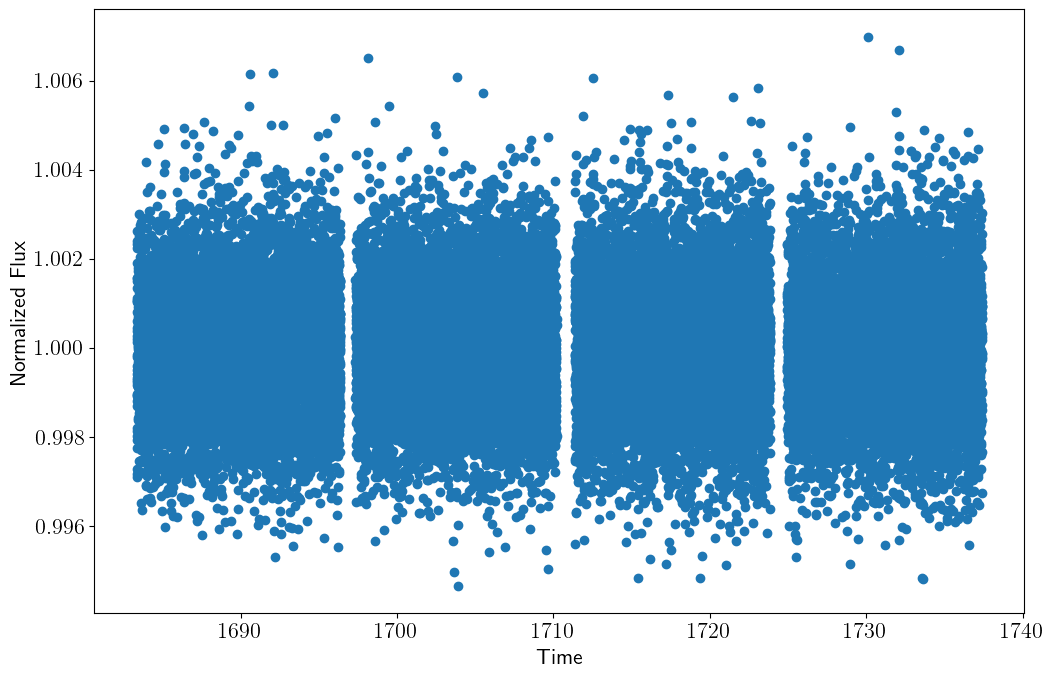

In [18]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

plt.scatter(flat_lc.time[no_flare],flat_lc.flux[no_flare]/np.nanmedian(flat_lc.flux[no_flare]))
#plt.xlim(539.4,540.4)
#plt.ylim(1.17,1.22)
#plt.xlim(1190,1200)
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

### Setting up the GP

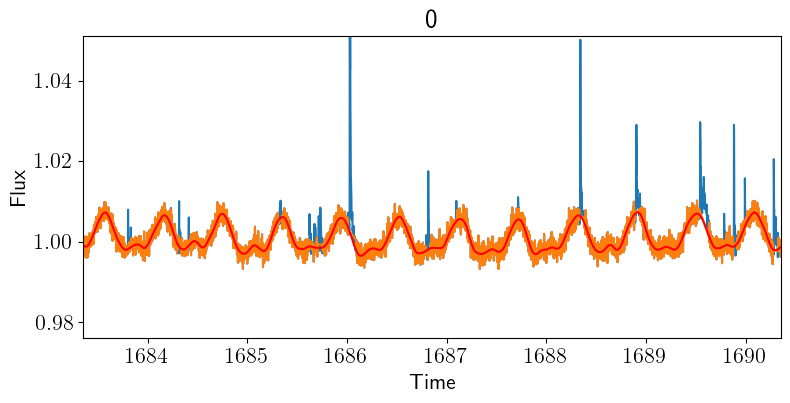

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead


>>>  0


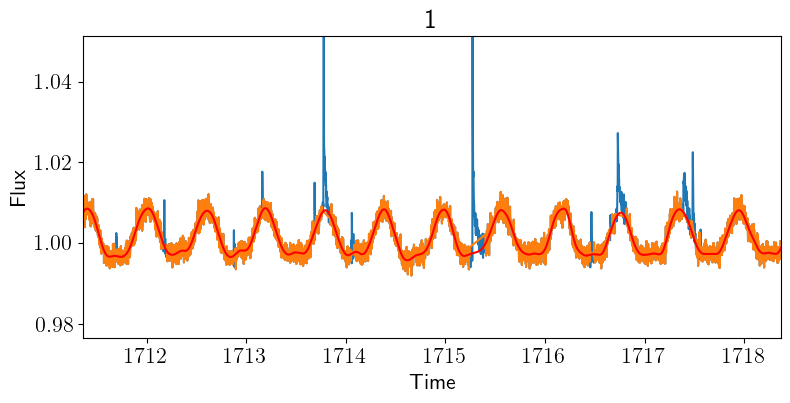

>>>  0


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead


In [44]:
for i in range (0,len(tess_collection)):
        #month is the times of each month w/o flares
        month = np.where((gj1243_tesslc.time[no_flare] >= np.min(tess_collection[i].time)) & 
                         (gj1243_tesslc.time[no_flare] <= np.max(tess_collection[i].time)))[0]
        
        
        y = medflux[month]
        t = gj1243_tesslc.time[no_flare][month]
        yerr = 1+((gj1243_tesslc.flux_err[no_flare][month] - np.nanmedian(gj1243_tesslc.flux[no_flare][month]))/(np.nanmedian(gj1243_tesslc.flux[no_flare][month])))
        yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)
        
        mok = np.where((np.abs(y-np.mean(y)) < 5*np.std(y)))
        y=y[mok]
        t=t[mok]
        yerr=yerr[mok]
        
#         if i==0:
        Q = 0.01
        w0 = 2*np.pi/0.59
        S0 = np.var(y) / (w0 * Q)
        bounds = dict(log_S0=(-15,15), log_Q=(-5,15), log_omega0=(0,15))
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)

#         print(i, np.mean(y), kernel.terms)
        
        #Running the gp
        gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
        gp.compute(t, yerr)  # You always need to call compute once.

        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)
        
#         if i==0:
        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()
        
#         print(initial_params)
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
#         print(r)
        
        gp.set_parameter_vector(r.x)

        month_flares = np.where((gj1243_tesslc.time >= np.min(tess_collection[i].time)) & 
                                (gj1243_tesslc.time <= np.max(tess_collection[i].time)))[0]
        x = gj1243_tesslc.time[month_flares]

        #### HOW TO MAKE IT GO SLOW
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        #### HOW TO MAKE IT GO FAST (w/o Variance)
        #pred_mean = gp.predict(y, x, return_cov=False, return_var=False)
        #pred_var = gj1243_tesslc.flux_err[month_flares]/total_median # NOT right, just a hack for right now...

        pred_std = np.sqrt(pred_var)
        #Saving each month of the gp run
        dict_i = {'time':x,'mean': pred_mean, 'std': pred_std, 'var': pred_var, 
                'detrended_flux':(1+((gj1243_tesslc.flux[month_flares] - med_nf[i]))/total_median),
                'df_flux_err':(gj1243_tesslc.flux_err[month_flares])/total_median}  
        gp_out = pd.DataFrame(data=dict_i) 
        gp_out.to_csv(r'tess_gp_values'+str(i)+'.csv',header=True,index=True)

        #plotting to make sure each month looks reasonable
        plt.figure(figsize=(9,4))
        plt.plot(x,(1+((gj1243_tesslc.flux[month_flares] - med_nf[i]))/total_median))
        plt.plot(t,y, c='C1')
        plt.plot(x,pred_mean, c='r')
        plt.xlabel("Time")
        plt.ylabel("Flux")
        plt.title(str(i))
        
        plt.xlim(np.min(x),np.min(x) + 7)
        plt.ylim(np.mean(y)-0.025, np.mean(y)+0.05)
        plt.show()
        
        print('>>> ',sum(np.isnan(pred_mean)))

In [45]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:log_S0', -14.7309091043436), ('kernel:log_Q', 1.306036705652891), ('kernel:log_omega0', 2.499833455909435), ('mean:value', 1.0013991174137105)])

parameter_names:
('kernel:log_S0', 'kernel:log_Q', 'kernel:log_omega0', 'mean:value')

parameter_vector:
[-14.7309091    1.30603671   2.49983346   1.00139912]

parameter_bounds:
[(-15, 15), (-5, 15), (0, 15), (None, None)]



In [46]:
print(r)

      fun: -80961.19102824415
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03201421, -0.02619345,  0.0523869 ,  4.46598281])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 330
      nit: 41
     njev: 66
   status: 0
  success: True
        x: array([-14.7309091 ,   1.30603671,   2.49983346,   1.00139912])


In [47]:
gp.get_parameter_dict()
print(2*np.pi /np.exp(gp.get_parameter_dict()['kernel:log_omega0']))

0.5158411604369495


Importing in the gp data from .csv file

0 (18522, 7)
1 (17848, 7)


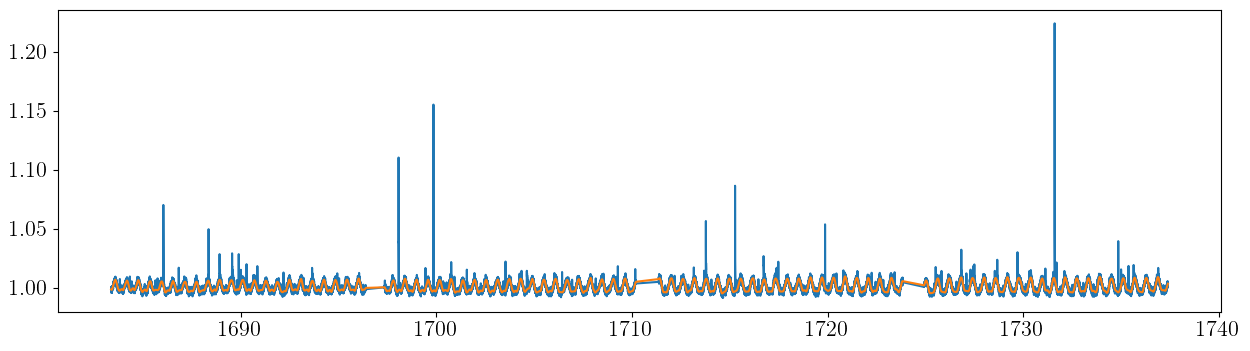

In [19]:
from glob import glob

gp_files = glob('*tess_gp*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()

Text(0.5, 0, 'Time - 2457000 [BTJD days]')

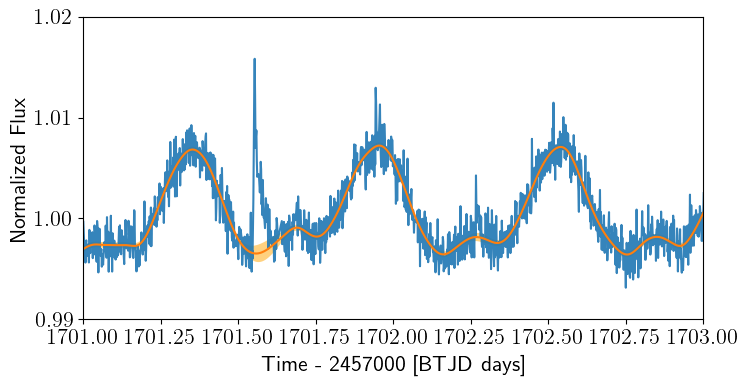

In [21]:
plt.figure(figsize=(8,4))

plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color='orange', alpha=0.5,
                 edgecolor="none",label='gp')


plt.xlim(1701,1703)
plt.ylim(.99,1.02)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

### Stacking the Flares (using stacking procedure from 2014)

In [22]:
detrended = df['detrended_flux'].values - df['mean'].values

In [28]:
print(len(detrended))

36370


In [23]:
min(df['time'].values)

1683.3561758891572

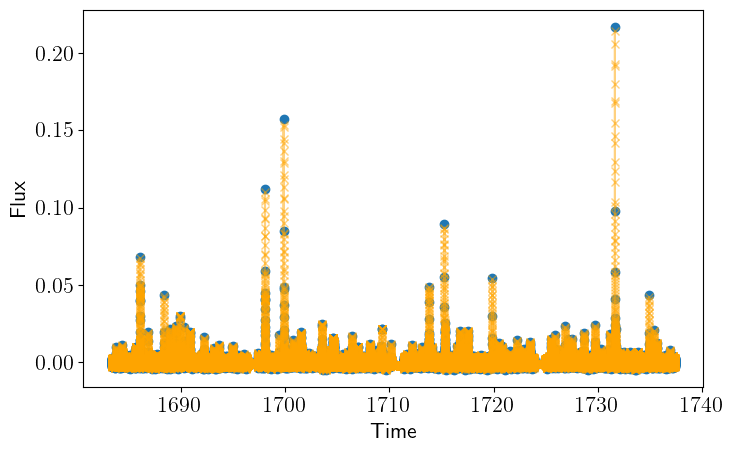

In [24]:
#interpolating the full light curve
plt.scatter(df['time'],detrended)

plt.xlabel("Time")
plt.ylabel("Flux")

padding_factor = 10
steps = padding_factor*len(detrended)

xvals = np.linspace(1683.35617589, 1737.41161827, steps)
yinterp = np.interp(xvals, df['time'], detrended)
plt.plot(xvals,yinterp,'-x',color='orange',alpha=0.5)

In [36]:
print(len(xvals))
print(len(tess_flares['t_stop'].values))
print(len(df['time'].values))

363700
134
36370


In [68]:
len(detrended)
len(df['time'])

36370

In [147]:
for i in range(0,61):
    test = np.where((df['time'].values < tess_flares['t_stop'].values[i]) & 
                    (df['time'].values > tess_flares['t_start'].values[i]))[0]
    (np.argmax(detrended[test]))

In [148]:
t2=np.where((df['time'].values < tess_flares['t_stop'].values[61]) & 
                    (df['time'].values > tess_flares['t_start'].values[61]))[0]

In [149]:
print(np.argmax(detrended))
print(np.argmax(detrended[t2]))

32209
0


In [150]:
(tess_flares)

,Event_ID,Start_INDX,Stop_INDX,t_peak,t_start,t_stop,t_rise,t_decay,Flux_peak,Equiv_Dur,S/N,CPLX_flg,MLTPK_flg,MLTPK_num,t_MLTPK,L_mltpk,MLTPK_INDX,quies,x
1,2,332.0,336.0,1683.831182,1683.828405,1683.833960,0.002778,0.002778,0.004359,1.039416,0.856315,4.0,0.0,0.0,0.0,0.0,0.0,11337.21094,;
2,3,618.0,622.0,1684.233965,1684.232576,1684.238132,0.001389,0.004167,0.004396,1.021397,0.698504,4.0,0.0,0.0,0.0,0.0,0.0,11377.51562,;
3,4,676.0,685.0,1684.315911,1684.313133,1684.325633,0.002778,0.009722,0.011388,4.056827,1.721060,4.0,0.0,0.0,0.0,0.0,0.0,11337.41602,;
4,5,1619.0,1628.0,1685.624261,1685.622872,1685.635372,0.001389,0.011111,0.007767,2.732755,1.365432,4.0,0.0,0.0,0.0,0.0,0.0,11342.76758,;
5,6,1655.0,1661.0,1685.674261,1685.672872,1685.681206,0.001389,0.006945,0.006291,1.887355,1.065632,4.0,0.0,0.0,0.0,0.0,0.0,11338.58984,;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,86,14676.0,14684.0,1732.993635,1732.990858,1733.001969,0.002778,0.008333,0.003867,1.682614,0.968132,4.0,0.0,0.0,0.0,0.0,0.0,10888.03809,;
129,87,15771.0,15776.0,1734.529720,1734.526942,1734.533887,0.002778,0.004167,0.004530,1.102805,0.865970,4.0,0.0,0.0,0.0,0.0,0.0,11007.02051,;
130,88,16160.0,16165.0,1735.072767,1735.068600,1735.075544,0.004167,0.002778,0.003405,0.353476,0.317556,4.0,0.0,0.0,0.0,0.0,0.0,11003.25879,;
131,89,16167.0,16171.0,1735.082489,1735.078322,1735.083877,0.004167,0.001389,0.002933,0.340924,0.356425,4.0,0.0,0.0,0.0,0.0,0.0,11012.22559,;


Finding the flux and time values where local maxes occur w/in interpolated data (i.e where the flares happen)

In [151]:
time_max = np.array([])
peaks = np.array([])
t_halfs = np.array([])
for i in range(0,len(tess_flares)):
    #for interpolated data
    temp1 = np.where((xvals < tess_flares['t_stop'].values[i]) & 
                    (xvals > tess_flares['t_start'].values[i]))[0]
    
    #for normal data
    temp2 = np.where((df['time'].values < tess_flares['t_stop'].values[i]) & 
                    (df['time'].values > tess_flares['t_start'].values[i]))[0]

    i_max = np.argmax(detrended[temp2])
    t_max = (df['time'].values[temp2][i_max])
    flux_max = (detrended[temp2][i_max])
    time_max = np.append(time_max,t_max)
    peaks = np.append(peaks,flux_max)
    half_peaks = peaks/2.0
    i_xs = np.where((yinterp[temp1] > half_peaks[i]))[0]
    time_xs = xvals[temp1][i_xs]
    t_half = max(time_xs) - min(time_xs)
    t_halfs = np.append(t_halfs,t_half)
    flux_fwhm = np.where(yinterp > half_peaks[i])[0]
  

In [38]:
print(i_max)

1


Plotting the stacked flares

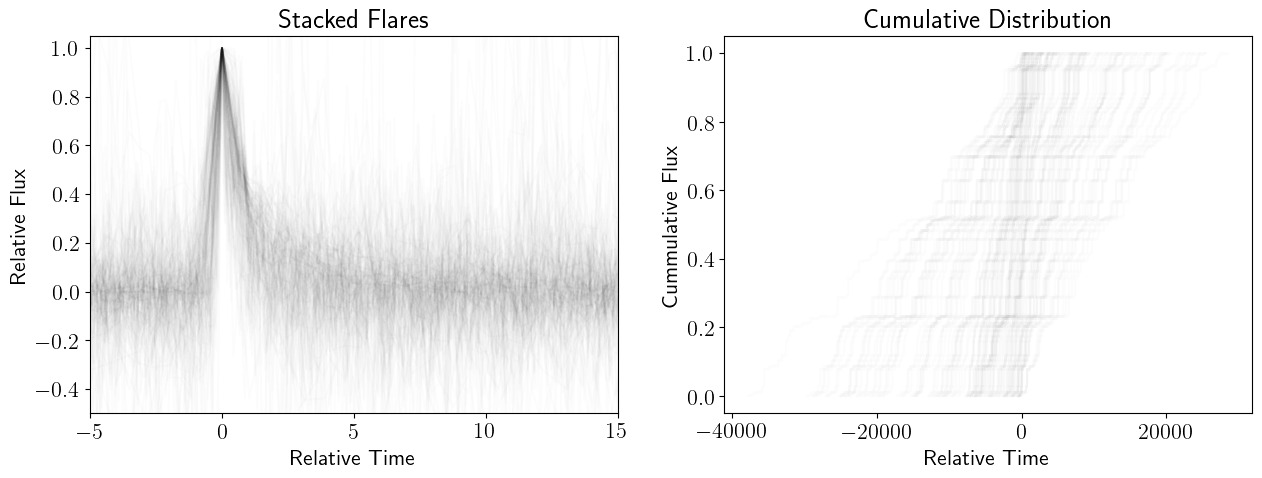

In [153]:

fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(tess_flares)):
    
    x = (df['time'] - time_max[i])/(t_halfs[i])
    y = ((detrended)/(peaks[i]))
    #plt.plot(x,y,color='b',alpha=0.01)


    axs[0].plot(x,y,color='k',alpha=0.01)

    #axs[1].plot((xinterp[2]-xinterp)/scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    #axs[1].plot((df['time'][temp])/scale_dur[i],cd_detrended,color='k',alpha=0.2)
    axs[1].plot(x,np.cumsum(y)/np.sum(y),color='k',alpha=0.01)
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-5,15)
    axs[0].set_ylim(-0.5,1.05) 

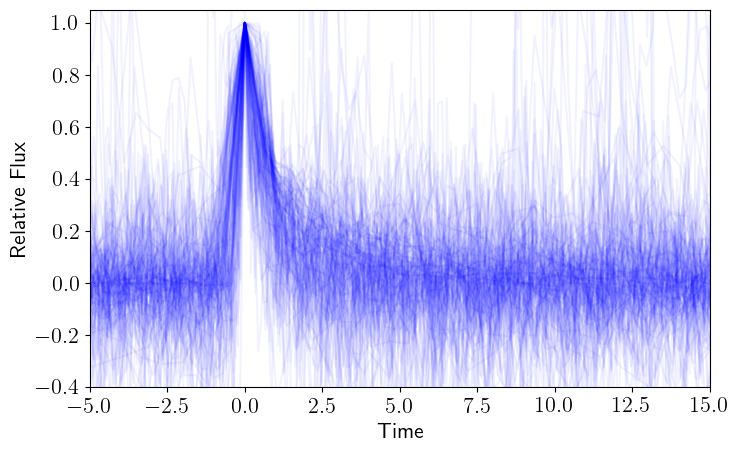

In [157]:

x_all=np.array([])
y_all=np.array([])
y_err = np.array([])
gp_st_dev = np.array([])
xmin=-5
xmax=15


for i in range(0,len(tess_flares)):
        x_new = (df['time'].values - time_max[i])/(t_halfs[i])
        y_new = ((detrended)/(peaks[i]))
        plt.plot(x_new,y_new,color='b',alpha=0.05)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)
        
        #Time Arrays
        nxs = np.where((x_new <= xmax) & (x_new>=xmin))[0]
        x_all = np.append(x_all,x_new[nxs])
        
        #Flux Arrays
        y_all = np.append(y_all,y_new[nxs])
        
        #Flux Errors
        flux_err = df['df_flux_err'].values/peaks[i] 
        y_err = np.append(y_err,flux_err[nxs])
        
        #GP Standard Deviation
        st_dev = df['std'].values/peaks[i]
        gp_st_dev = np.append(gp_st_dev,st_dev[nxs])
                  
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [158]:
#saving the arrays to a file
#dict_i = {'time':x_all,'flux': y_all, 'flux_err': y_err, 'gp_st_dev': gp_st_dev} 
#tess_stacked_flares = pd.DataFrame(data=dict_i) 
#tess_stacked_flares.to_csv(r'tess_stacked_flare_values.csv',header=True,index=True)


In [159]:
tess_stacked_flare_vals=pd.read_csv('tess_stacked_flare_values.csv')

Text(0, 0.5, 'Relative Flux')

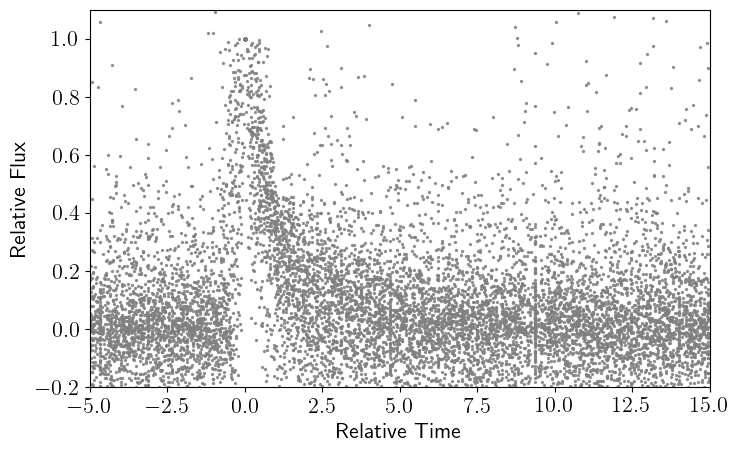

In [167]:

tess_time = tess_stacked_flare_vals['time'].values
tess_flux = tess_stacked_flare_vals['flux'].values
tess_flux_err = tess_stacked_flare_vals['flux_err'].values
tess_gp_err = tess_stacked_flare_vals['gp_st_dev'].values

tess_both_errors = np.sqrt( (tess_flux_err)**2 + (tess_gp_err)**2 )

tess_sort = np.argsort(tess_time)
plt.scatter(tess_time[tess_sort],tess_flux[tess_sort],alpha=.8,s=8,marker='.',color='grey')
plt.ylim(-0.2,1.1)
plt.xlim(-5,15)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.savefig('/Users/lupitatovar/flares/figures/fit_stacked_flares.png',bbox_inches='tight')

In [203]:
print(tess_sort)
print(tess_time)
print(tess_time[tess_sort])

[   75  1616  1524 ... 10002   441  8627]
[-4.91838269 -4.42654436 -3.93470612 ... 13.70550609 14.32848364
 14.9514612 ]
[-4.98395921 -4.98395116 -4.98395075 ... 14.98670372 14.99080716
 14.99329572]


In [178]:
from scipy import special
def flare_model(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

In [179]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

In [207]:
def flare_model_v2(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [3.09376901,  3.74111441, -0.24209949,  0.11042946,  1.32430633,  0.17351056]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

In [208]:
jim_model = aflare1(tess_time,0,1,1)
new_model = flare_model(tess_time,0,1,1)
model_v2 = flare_model_v2(tess_time,0,1,1)

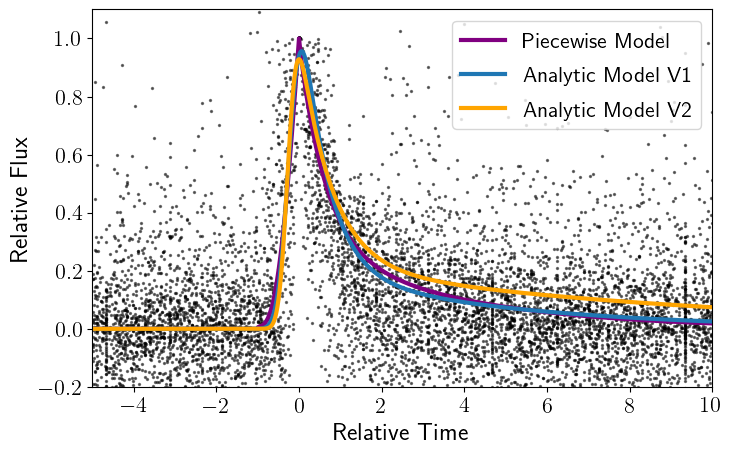

In [209]:
plt.scatter(tess_time[tess_sort],tess_flux[tess_sort],alpha=.5,s=8,marker='.',color='k')
plt.plot(tess_time[tess_sort],jim_model[tess_sort],color='purple',lw=3,label='Piecewise Model')
plt.plot(tess_time[tess_sort]-2,new_model[tess_sort],color='C0',lw=3, label = 'Analytic Model V1')
plt.plot(tess_time[tess_sort]-2,model_v2[tess_sort],color='orange',lw=3, label = 'Analytic Model V2')
plt.ylim(-0.2,1.1)
plt.xlim(-5,10)
plt.xlabel("Relative Time",fontsize='18')
plt.ylabel("Relative Flux",fontsize='18')
plt.legend( loc='upper right')#, borderaxespad=0.)
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_stacked_flares.pdf')